In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
stock = "GOOGL"
df = pd.DataFrame(yf.download(stock, '2010-01-01', '2022-12-31')["Close"])

[*********************100%***********************]  1 of 1 completed


In [3]:
def rolling(lag, data):
    A = []
    df = data.tolist()
    for i in range(lag, len(df)):
        A.append(df[i-lag:i]) 
    return pd.DataFrame(A)

def MLP(x,y):
    model = MLPClassifier()
    model.fit(x,y)
    return model

def UoD(x):
    if x<0:
        return -1
    else: 
        return 1
    
def train_test_split(x,y,test_size):
    i = int(len(x)*test_size)
    j = int(len(y)*test_size)
    return x[:i], x[i:], y[:j], y[j:]

In [4]:
df["returns"] =df.pct_change()
df["UoD"]= df["returns"].map(UoD)

In [5]:
lag = 3
A = rolling(lag, df["Close"])
b = df["UoD"][lag::]
deon, dete, keyon, keyte = train_test_split(A,b, test_size=0.3)

In [6]:
a = MLP(deon, keyon)
accuracy_score(keyte, a.predict(dete))

0.528178243774574

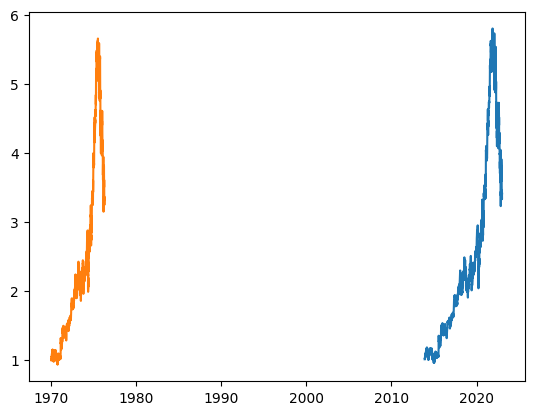

In [21]:
re2 = df["returns"][int(0.3*len(df["returns"])):]
plt.plot(np.cumprod(1+re2))
plt.plot()

array([2, 4, 8, ..., 0, 0, 0], dtype=int64)

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql


# In[6]:


db_connection = pymysql.connect(host='13.251.234.97', user='bi_all', passwd='vela.12345', db='python_prj')
# cur = conn.cursor()
# hsx
df1 = pd.read_sql("""select * from HSX_data""", con=db_connection)
# hnx
df2 = pd.read_sql("""select * from HNX_data""", con=db_connection)
df = pd.concat([df1, df2], axis=0)
# vn30 ky 1 2019
ticket = ['CII','CTD','CTG','DHG','DPM','EIB','FPT','GAS','GMD','HDB','HPG','MBB','MSN','MWG','NVL','PNJ','REE','ROS','SAB','SBT','SSI','STB','TCB','VCB','VHM','VIC','VJC','VNM','VPB','VRE']
frames = [df[df['<Ticker>']== 'CII'],
          df[df['<Ticker>']== 'CTD'],
          df[df['<Ticker>']== 'CTG'],
          df[df['<Ticker>']== 'DHG'],
          df[df['<Ticker>']== 'DPM'],
          df[df['<Ticker>']== 'EIB'],
          df[df['<Ticker>']== 'FPT'],
          df[df['<Ticker>']== 'GAS'],
          df[df['<Ticker>']== 'GMD'],
          df[df['<Ticker>']== 'HDB'],
          df[df['<Ticker>']== 'HPG'],
          df[df['<Ticker>']== 'MBB'],
          df[df['<Ticker>']== 'MSN'],
          df[df['<Ticker>']== 'MWG'],
          df[df['<Ticker>']== 'NVL'],
          df[df['<Ticker>']== 'PNJ'],
          df[df['<Ticker>']== 'REE'],
          df[df['<Ticker>']== 'ROS'],
          df[df['<Ticker>']== 'SAB'],
          df[df['<Ticker>']== 'SBT'],
          df[df['<Ticker>']== 'SSI'],
          df[df['<Ticker>']== 'STB'],
          df[df['<Ticker>']== 'TCB'],
          df[df['<Ticker>']== 'VCB'],
          df[df['<Ticker>']== 'VHM'],
          df[df['<Ticker>']== 'VIC'],
          df[df['<Ticker>']== 'VJC'],
          df[df['<Ticker>']== 'VNM'],
          df[df['<Ticker>']== 'VPB'],
          df[df['<Ticker>']== 'VRE']
         ]
df = pd.concat(frames)
vn_index_df = pd.read_sql("""select * from INDEX_data""", con=db_connection)

def setting(alpha):
    # Set weight > 0
    alpha = alpha.sub(alpha.min(axis=1), axis=0)
    # Normalize
    alpha = alpha.div(alpha.sum(axis=1), axis=0)
    # Set none if nan > 20
    di = alpha.index.where(alpha.isnull().sum(axis = 1) >= 20)
    di = di[~np.isnan(di)]
    alpha.loc[di] = None
    # Max stock weight = 0.2
    alpha[alpha > 0.2] = 0.2
    return alpha


def get_sharpe(values):
    try:
        return np.mean(values)/np.std(values)*np.sqrt(252)
    except Exception:
        return 0
    
    
def drop_value(data):
    return data.drop(data[(data.index < 20090000) | (data.index > 20189999)].index)


class SimResult(object):
    def __init__(self, weights, date_idx, booksize):
        self.weights = weights
        self.booksize = booksize
        self.date_idx = date_idx
    
    def get_turnover(self):
        weights_t = self.weights[1:,:]
        weights_t1 = self.weights[:-1,:]
        turnover = np.nansum(np.abs(weights_t - weights_t1), axis = 1)
        return turnover
    
    def get_portfolio_returns(self):
        res = np.nansum(self.weights[:-1,:]*returns, axis = 1)
        return res
        
    def get_pnl(self):
        pnl = self.booksize*np.nansum(self.weights[:-1,:]*returns, axis = 1)
        return pnl
    
    def get_count(self):
        return np.sum(~np.isnan(self.weights[:-1,:]*returns), axis = 1)
         
    def get_stats_table(self):
        year_idx = self.date_idx.year
        returns_p = self.get_portfolio_returns()        
        pnl = self.get_pnl()
        turnover = self.get_turnover()
        count = self.get_count()
        
        temp_df = pd.DataFrame(np.array([returns_p, pnl, turnover, turnover, year_idx[1:], pnl/turnover, count]).T, columns =['returns', 'pnl', 'sumturnover', 'turnover','year_idx', 'margin', 'count']).reset_index()
        temp_df = temp_df.groupby('year_idx').agg({'returns': get_sharpe, 'pnl': 'sum', 'sumturnover': np.nansum, 'turnover': np.nanmean, 'margin': np.sum, 'count': np.mean})
        temp_df['margin'] = temp_df.pnl/temp_df.sumturnover*1000
        temp_df['returns_'] = temp_df.pnl/self.booksize *100
        temp_df['turnover'] = temp_df.turnover*100
        temp_df['count'] = temp_df['count'].round(0)
        temp_df.rename(columns = {'returns':'sharpe'}, inplace= True)
        # fitness
        temp_df['fitness'] = temp_df['sharpe']*np.sqrt(np.abs(temp_df['returns_']/temp_df.turnover))
        temp_df.drop(columns=['sumturnover'], inplace = True)
        # all time
        sharpe = get_sharpe(returns_p)
        turnover = np.mean(self.get_turnover())*100
        pnl = np.sum(self.get_pnl())
        returns_p = np.mean(temp_df['returns_'])
        fitness = sharpe*np.sqrt(np.abs(returns_p/turnover))
        margin = pnl/np.nansum(self.get_turnover())*1000
        count = np.round(np.mean(self.get_count()))
        temp_df.loc['2009-2018'] = [sharpe, pnl, turnover, margin, count, returns_p, fitness,]
        return temp_df

    def get_corr(self):
        print('Correlation', np.corrcoef(self.get_portfolio_returns(), vn_index_return)[0][1])
        
    def plot_pnl(self):
        pnl = self.get_pnl()
        cum_pnl = np.cumsum(pnl)
        vn_pnl = np.cumsum(vn_index_return)
        plt.plot(date_idx[:-1], cum_pnl, '-r')
        plt.plot(date_idx[:-1], vn_pnl, '-b')
        plt.legend(['alpha', 'vnindex'], loc='upper left')
        plt.show()


# Note: dropna = False
# Calculate returns
close_df = df.pivot_table(index = '<DTYYYYMMDD>', columns='<Ticker>', values = '<Close>', dropna=False)
close_df = drop_value(close_df)
closes = drop_value(close_df).values
closes_t = closes[1:,]
closes_t1 = closes[:-1, :]
returns = (closes_t - closes_t1)/closes_t1

# Calculate returns
vn_index_pivot = vn_index_df.pivot_table(index = '<DTYYYYMMDD>', columns='<Ticker>', values = '<Close>', dropna=False)['VNINDEX']
vn_index_pivot = drop_value(vn_index_pivot)
# clean
vn_index = vn_index_pivot.drop(vn_index_pivot.index[np.where(~drop_value(vn_index_pivot).index.isin(close_df.index))]).values
vn_index_t = vn_index[1:]
vn_index_t1 = vn_index[:-1]
vn_index_return = (vn_index_t - vn_index_t1)/vn_index_t1
sharpe_index = get_sharpe(vn_index_return)
pnl_index = np.sum(vn_index_return)


# In[9]:


# delay(close, 5)
close = df.pivot_table(index = '<DTYYYYMMDD>', columns='<Ticker>', values = '<Close>', dropna=False)
close_5 = close.shift(5)
# - delta(close,5)
alpha = -(close - close_5)
alpha = setting(alpha)


# In[10]:


weights= drop_value(alpha).values
date_idx = pd.to_datetime(drop_value(alpha).index.astype(str), format = '%Y%m%d')


# In[11]:


simResult = SimResult(weights, date_idx, 1)


# In[12]:


simResult.plot_pnl()
temp_df = simResult.get_stats_table()
# vn_index
temp_df.loc['vn_index'] = [sharpe_index,
                           pnl_index,
                           None,
                           None,
                           None,
                           np.nansum(vn_index_return)*10,
                           None]
print(temp_df)
simResult.get_corr()
